# Семинар 8: Metric learning for face recognition

<img src="https://insightface.ai/assets/img/github/facerecognitionfromvideo.PNG" alt="drawing" width="800"/>

## Содержание семинара
На этом семинаре мы
1. Поставим задачу распознавания лиц.
2. Опишем в общем виде pipeline для решения задачи распознавания.
3. Разберём нейросетевые модели на базе Softmax и [ArcFace](https://arxiv.org/abs/1801.07698) функций потерь, используемую для получения грубоких представлений.
4. Разберём пример обучения модели с помощью Triplet Loss
5. Визуализируем полученные представления и сравним методы Metric Learning
6. Применим полученные знания для решения задачи распознавания лиц на наборе данных [EasyPortrait](https://github.com/ai-forever/easyportrait).
7. Решим задачу открытой идентификации на наборе данных IJB-C

## 4. Обучение Softmax модели на небольшом наборе данных

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import mxnet as mx
import numbers
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import os
from pathlib import Path

In [3]:
class MXFaceDataset(Dataset):
    def __init__(self, root_dir, num_labels, test=False):
        """
        ArcFace loader
        https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/dataset.py
        """
        super(MXFaceDataset, self).__init__()

        self.test = test
        if self.test:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ]
            )
        self.root_dir = root_dir
        path_imgrec = os.path.join(root_dir, "train.rec")
        path_imgidx = os.path.join(root_dir, "train.idx")
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, "r")
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))
        labels_path = Path(root_dir) / "labels.npy"
        if labels_path.is_file:
            self.labels = np.load(labels_path)
        else:
            labels = []
            for i in tqdm(range(len(self.imgidx))):
                idx = self.imgidx[i]
                s = self.imgrec.read_idx(idx)
                header, img = mx.recordio.unpack(s)
                label = header.label
                labels.append(int(label))
            labels = np.array(labels)
            np.save(labels_path, labels)
        unique_labels, unique_counts = np.unique(self.labels, return_counts=True)
        top_ids = np.argsort(unique_counts)[::-1][:num_labels]
        self.top_labels = unique_labels[top_ids]

        self.label_map = dict(
            zip(self.top_labels.tolist(), np.arange(len(self.top_labels)))
        )

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = self.label_map[int(label)]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        if self.test:
            return sample
        else:
            return sample, label

    def __len__(self):
        return len(self.imgidx)

In [4]:
num_labels = 3
ms1m_dataset = MXFaceDataset("data/ms1m/", num_labels=num_labels)
people_ids = np.where(np.isin(ms1m_dataset.labels, ms1m_dataset.top_labels))[0]
people_set = torch.utils.data.Subset(ms1m_dataset, people_ids)

### Задание модели

In [5]:
from iresnet import iresnet50_normalized


class MetricLearningModel(pl.LightningModule):
    def __init__(
        self, backbone: torch.nn.Module, loss: torch.nn.Module, num_labels: int
    ):
        super().__init__()
        self.backbone = backbone
        self.loss = loss
        self.softmax_weights = torch.nn.Parameter(
            torch.zeros(2, num_labels), requires_grad=True
        )

    def forward(self, x):
        backbone_outputs = self.backbone(x)
        features = backbone_outputs["feature"]
        logits = torch.matmul(features, F.normalize(self.softmax_weights, dim=0))
        return features, logits

    def training_step(self, batch):
        images, labels = batch
        features, logits = self(images)
        loss = self.loss(logits, labels)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        params = list(self.backbone.parameters()) + [self.softmax_weights]
        optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=5e-3)
        return {
            "optimizer": optimizer,
        }


backbone_model = iresnet50_normalized(num_features=2)
softmax_loss = torch.nn.CrossEntropyLoss()
arcface_model = MetricLearningModel(backbone_model, softmax_loss, num_labels=num_labels)

In [6]:
batch_size = 64
num_workers = 10

In [7]:
from pytorch_lightning import Trainer
import pytorch_lightning as pl

trainer = Trainer(max_epochs=10, default_root_dir="outputs/softmax_train")
train_dataloader = DataLoader(
    people_set,
    batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)
trainer.fit(arcface_model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWar

LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | IResNetNorm      | 30.8 M
1 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
30.8 M    Trainable params
2         Non-trainable params
30.8 M    Total params
123.178   Total estimated model params size (MB)
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it, v_num=9, train_loss=0.447]


### Вычисление представлений

In [8]:
backbone_model = iresnet50_normalized(num_features=2)
softmax_loss = torch.nn.CrossEntropyLoss()
checkpoint_path = "/app/spring_2023/s8_face_recognition/outputs/softmax_train/lightning_logs/version_8/checkpoints/epoch=9-step=130.ckpt"
softmax_model = MetricLearningModel.load_from_checkpoint(
    num_labels=num_labels,
    backbone=backbone_model,
    loss=softmax_loss,
    checkpoint_path=checkpoint_path,
)

In [9]:
len(people_set)

1786

In [10]:
def predict_features(model):
    test_dataloader = DataLoader(
        people_set,
        batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
    )
    cuda = torch.device("cuda")
    model  # .to(cuda)
    # disable randomness, dropout, etc...
    model.eval()
    predicted_features = []
    image_labels = []
    for batch in tqdm(test_dataloader):
        images, labels = batch
        images = images  # .to(cuda)
        features, _ = model(images)
        features = features.detach().cpu().numpy()
        labels = labels.numpy()
        predicted_features.append(features)
        image_labels.append(labels)
    predicted_features = np.concatenate(predicted_features)
    image_labels = np.concatenate(image_labels)
    return predicted_features, image_labels

In [11]:
predicted_features, image_labels = predict_features(softmax_model)

100%|██████████| 28/28 [02:42<00:00,  5.80s/it]


Epoch 9: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it, v_num=9, train_loss=0.447]

In [12]:
softmax_weights = softmax_model.softmax_weights.detach().cpu()

In [13]:
softmax_weights = F.normalize(softmax_weights, dim=0).numpy()

In [14]:
softmax_weights

array([[ 0.70710695, -0.70710677, -0.70710677],
       [-0.70710665,  0.7071069 , -0.7071068 ]], dtype=float32)

In [15]:
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS)[:num_labels]

In [17]:
colors

['tab:blue', 'tab:orange', 'tab:green']

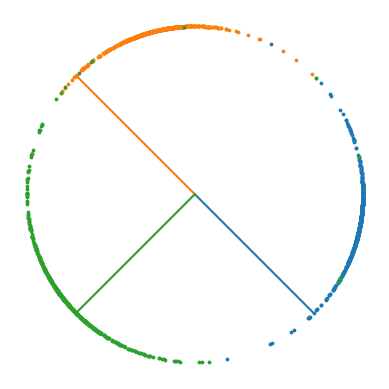

In [16]:
import matplotlib.pyplot as plt

max_classes = 4
for i, (weight, color) in enumerate(zip(softmax_weights.T, colors)):
    points = predicted_features[image_labels == i]
    x, y = [0, weight[0]], [0, weight[1]]
    plt.plot(x, y, marker="", c=color)
    plt.scatter(points[:, 0], points[:, 1], color=color, s=3)
    if i == (max_classes - 1):
        break
plt.gca().set_aspect("equal")
plt.axis("off")
plt.show()

## 5. Решение задачи верификации на наборе данных EasyPortrait
Давайте возьмём набор данных [EasyPortrait](https://github.com/ai-forever/easyportrait), сформулируем для него задачу верификации и решим её с помощью предобученной ArcFace модели. 

### Подготовка данных

In [3]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt


data_dir = Path("data/easy_portrait")
data_dir.mkdir(exist_ok=True, parents=True)
images_dir = data_dir / "images"
images_dir.mkdir(exist_ok=True)

In [5]:
#!wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/images.zip -O data/images.zip
!unzip -q data/images.zip -d data/easy_portrait/images

In [4]:
# !wget https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/annotations.zip -O data/annotations.zip

# !unzip data/annotations.zip -d data/easy_portrait
# !unzip data/easy_portrait/meta.zip -d data/easy_portrait

--2023-09-28 08:10:46--  https://n-ws-620xz-pd11.s3pd11.sbercloud.ru/b-ws-620xz-pd11-jux/easyportrait/annotations.zip
Resolving n-ws-620xz-pd11.s3pd11.sbercloud.ru (n-ws-620xz-pd11.s3pd11.sbercloud.ru)... 37.230.193.56
Connecting to n-ws-620xz-pd11.s3pd11.sbercloud.ru (n-ws-620xz-pd11.s3pd11.sbercloud.ru)|37.230.193.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245777384 (234M) [application/zip]
Saving to: ‘data/annotations.zip’

data/annotations.zi 100%[===================>] 234.39M  25.7MB/s    in 9.2s    

2023-09-28 08:10:56 (25.3 MB/s) - ‘data/annotations.zip’ saved [245777384/245777384]

Archive:  data/annotations.zip
   creating: data/easy_portrait/val/
  inflating: data/easy_portrait/val/f5918bb3-ba04-4db7-9762-bb3b1345d810.png  
  inflating: data/easy_portrait/val/2b40c938-3c1a-412f-8f87-b135b07fde67.png  
  inflating: data/easy_portrait/val/2ffb95ea-7579-46fd-8f80-0f406850e39e.png  
  inflating: data/easy_portrait/val/756482b9-a0e7-47bd-b9c4-9c6

#### Вычисление глубоких представлений

С помощью детектора лиц [SCRFD](https://arxiv.org/pdf/2105.04714.pdf) и [ArcFace](https://arxiv.org/abs/1801.07698) модели на базе [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), обученной на наборе данных [WebFace600K](https://www.face-benchmark.org/download.html), получим представления лиц набора EasyPortrait.

In [1]:
import torch
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
    root="./data/insightface",
)
app.prepare(ctx_id=0, det_size=(640, 640))
img = ins_get_image("t1")
faces = app.get(img)
rimg = app.draw_on(img, faces)
cv2.imwrite("data/t1_output.jpg", rimg)

download_path: ./data/insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:09<00:00, 30122.57KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_alloc': '0', 'device_id': '0'}}
find model: ./data/insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'cudnn_conv_use_max_workspace': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'gpu_external_alloc': '0', 'device_id': '0'}}
find model: ./d

/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


True

## Вычисление векторных представлений

In [4]:
face_meta = pd.read_csv("data/easy_portrait/meta.csv")

image_paths = []
user_ids = []
embeddings = []
for i, record in tqdm(face_meta.iterrows(), total=20000):
    if record["test"] is True:
        subset = "test"
    if record["train"] is True:
        subset = "train"
    if record["valid"] is True:
        subset = "val"
    image_path = str(images_dir / subset / (record["attachment_id"] + ".jpg"))
    image = cv2.imread(image_path)
    faces = app.get(image)

    if len(faces) == 1:
        image_paths.append(image_path)
        user_ids.append(record["user_id"])
        embeddings.append(faces[0].normed_embedding[np.newaxis, :])
embeddings = np.concatenate(embeddings)

  0%|          | 0/20000 [00:00<?, ?it/s]/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
100%|██████████| 20000/20000 [28:52<00:00, 11.55it/s]


In [5]:
# save embeddings and meta data
embeddings_dir = Path("data/embeddings")
embeddings_dir.mkdir(exist_ok=True)
np.save(embeddings_dir / "image_paths.npy", np.array(image_paths))
np.save(embeddings_dir / "user_ids.npy", np.array(user_ids))
np.save(embeddings_dir / "embeddings.npy", embeddings)

## Определение протокола верификации

Множество изображений для каждого человека разобъём на 2 равных случайных шаблона, которые затем будем использовать для подсчёта точности верификации. 

Мы хотим составить список пар изображение, среди которых будут пары изображений одного и того же человека и изображения разных людей.  
Для составления негативных пар возьмём из каждого шаблона по одному изображению и выпишем множество всевозможных пар шаблонов.  
Для составления позитивных пар возьмём всевозможные пары в шаблоне для каждого человека.

In [6]:
user_ids = np.load(embeddings_dir / "user_ids.npy")
embeddings = np.load(embeddings_dir / "embeddings.npy")
image_paths = np.load(embeddings_dir / "image_paths.npy")

face_meta = pd.DataFrame(
    {
        "user_id": user_ids,
        "image_path": image_paths,
        "embedding_id": np.arange(len(embeddings)),
    }
)

In [7]:
embeddings.shape

(19682, 512)

In [8]:
len(image_paths)

19682

In [9]:
# split images to templates
seed = 0
rs = np.random.default_rng(seed)

template_ids = []
template_user_ids = []
template_emb_ids = []
for i, (user_id, user_data) in enumerate(face_meta.groupby("user_id")):
    if user_data.user_id.values[0] == "nan":
        continue
    num_images = len(user_data)
    if num_images == 1:
        # single image template
        template_ids += [2 * i]
        template_user_ids += [user_id]
        template_emb_ids += user_data["embedding_id"].values.tolist()
    else:
        # split template in two random halves
        random_order_ids = rs.permutation(num_images)
        first_template_data = user_data.iloc[random_order_ids[: num_images // 2]]
        second_template_data = user_data.iloc[random_order_ids[num_images // 2 :]]
        template_ids += [2 * i] * len(first_template_data)
        template_ids += [2 * i + 1] * len(second_template_data)

        template_user_ids += first_template_data["user_id"].values.tolist()
        template_user_ids += second_template_data["user_id"].values.tolist()

        template_emb_ids += first_template_data["embedding_id"].values.tolist()
        template_emb_ids += second_template_data["embedding_id"].values.tolist()
templates = pd.DataFrame(
    {
        "template_id": template_ids,
        "user_id": template_user_ids,
        "embedding_id": template_emb_ids,
    }
)
templates.to_csv(embeddings_dir / "templates.csv", index=False)

In [11]:
templates.head(10)

,template_id,user_id,embedding_id
0,0,000846d038cc6289acf99f0739820896,3089
1,1,000846d038cc6289acf99f0739820896,5996
2,2,00099c87ff8a19643dbd31bf93bb1436,15643
3,4,00144dc200f186ef726669e9cd1332b7,5514
4,6,00147a746157ebb329c05140a2bf2517,7738
5,8,00199404ae6d1063db15036c13c11220,7966
6,10,00302ddd5c724605f069844551d556ee,16190
7,12,0035661ffcd9e638a7be40a26bf12f32,14016
8,14,0037b7b1bf9e84f38c0808fb7bcdbcf2,16624
9,16,0041ec866777f12c384b64d8cd636277,4299


In [12]:
# list positive and negative pairs

templates = pd.read_csv(embeddings_dir / "templates.csv")

In [13]:
first_template_positive = []
second_template_positive = []


# add positive pairs
for i, (user_id, user_data) in enumerate(templates.groupby("user_id")):
    unique_templates = user_data["template_id"].unique()
    if len(unique_templates) == 1:
        continue
    else:
        assert len(unique_templates) == 2
        first_template_positive += [unique_templates[0]]
        second_template_positive += [unique_templates[1]]

# add negative pairs
# from each subject first template is taken to match with others
user_to_template_id = {}
for i, (user_id, user_data) in enumerate(templates.groupby("user_id")):
    unique_templates = user_data["template_id"].unique()
    user_to_template_id[user_id] = unique_templates[0]
unique_user_ids = templates["user_id"].unique()

first_template_negative = []
second_template_negative = []

for first_id in tqdm(unique_user_ids):
    for second_id in unique_user_ids:
        if second_id == first_id:
            continue
        first_template_negative.append(user_to_template_id[first_id])
        second_template_negative.append(user_to_template_id[second_id])

100%|██████████| 8262/8262 [00:28<00:00, 294.86it/s]


In [14]:
first_template_negative = np.array(first_template_negative)
second_template_negative = np.array(second_template_negative)
first_template_positive = np.array(first_template_positive)
second_template_positive = np.array(second_template_positive)

In [15]:
len(first_template_positive), len(first_template_negative)

(2712, 68252382)

In [16]:
negative_pair_size = 5000000
seed = 0
rs = np.random.default_rng(seed)
random_order_ids = rs.permutation(len(first_template_negative))
negative_ids = random_order_ids[:negative_pair_size]
first_template = np.concatenate(
    [first_template_positive, first_template_negative[negative_ids]]
)
second_template = np.concatenate(
    [second_template_positive, second_template_negative[negative_ids]]
)
is_positive = [True] * len(first_template_positive) + [False] * len(negative_ids)

pairs = pd.DataFrame(
    {
        "first_template": first_template,
        "second_template": second_template,
        "is_positive": is_positive,
    }
)
pairs.to_csv(embeddings_dir / "pairs.csv", index=False)

### Подсчёт метрик точности верификации

In [17]:
pairs = pd.read_csv(embeddings_dir / "pairs.csv")
templates = pd.read_csv(embeddings_dir / "templates.csv")
embeddings = np.load(embeddings_dir / "embeddings.npy")

In [18]:
templates

,template_id,user_id,embedding_id
0,0,000846d038cc6289acf99f0739820896,3089
1,1,000846d038cc6289acf99f0739820896,5996
2,2,00099c87ff8a19643dbd31bf93bb1436,15643
3,4,00144dc200f186ef726669e9cd1332b7,5514
4,6,00147a746157ebb329c05140a2bf2517,7738
...,...,...,...
19551,16515,ffca0a846eea5f01deeab72e9f407428,15568
19552,16516,ffce02f942d36b6338290d0580dcb779,10100
19553,16518,ffddd372a507d5c234343da1af4a23c9,16191
19554,16520,fff39c130e0a6cbad6f96964f1756b73,16946


In [19]:
# pool template embs
template_pooled_embs = []
for i, (template_id, template_data) in enumerate(templates.groupby("template_id")):
    emb_ids = template_data["embedding_id"].values
    template_embeddinds = embeddings[emb_ids]
    mean_emb = np.mean(template_embeddinds, axis=0, keepdims=True)
    template_pooled_embs.append(mean_emb / np.linalg.norm(mean_emb))
template_pooled_embs = np.concatenate(template_pooled_embs)

In [20]:
unique_templates = templates["template_id"].unique()
template2id = np.zeros(max(unique_templates) + 1, dtype=int)
template2id[unique_templates] = np.arange(len(unique_templates))


def distance_function(X_1, X_2):
    return np.sum(X_1 * X_2, axis=1)


p1 = pairs["first_template"].values
p2 = pairs["second_template"].values

batch_size = 10000
steps = int(np.ceil(len(p1) / batch_size))
scores = []
for id in tqdm(range(steps), "Verification"):
    feat1 = template_pooled_embs[
        template2id[p1[id * batch_size : (id + 1) * batch_size]]
    ]
    feat2 = template_pooled_embs[
        template2id[p2[id * batch_size : (id + 1) * batch_size]]
    ]
    scores.extend(distance_function(feat1, feat2))
scores = np.array(scores)

Verification: 100%|██████████| 501/501 [00:12<00:00, 40.41it/s]


In [21]:
def draw_score_distr_plot(scores_distr, positive_pair_name, negative_pair_name):
    sns.set_theme()
    plt.figure(figsize=(12, 8))
    sns.distplot(
        scores_distr[positive_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=positive_pair_name,
    )
    sns.distplot(
        scores_distr[negative_pair_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=negative_pair_name,
    )

    plt.xlabel(f"Косинусная схожесть")

    plt.legend()

/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/erlygin/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


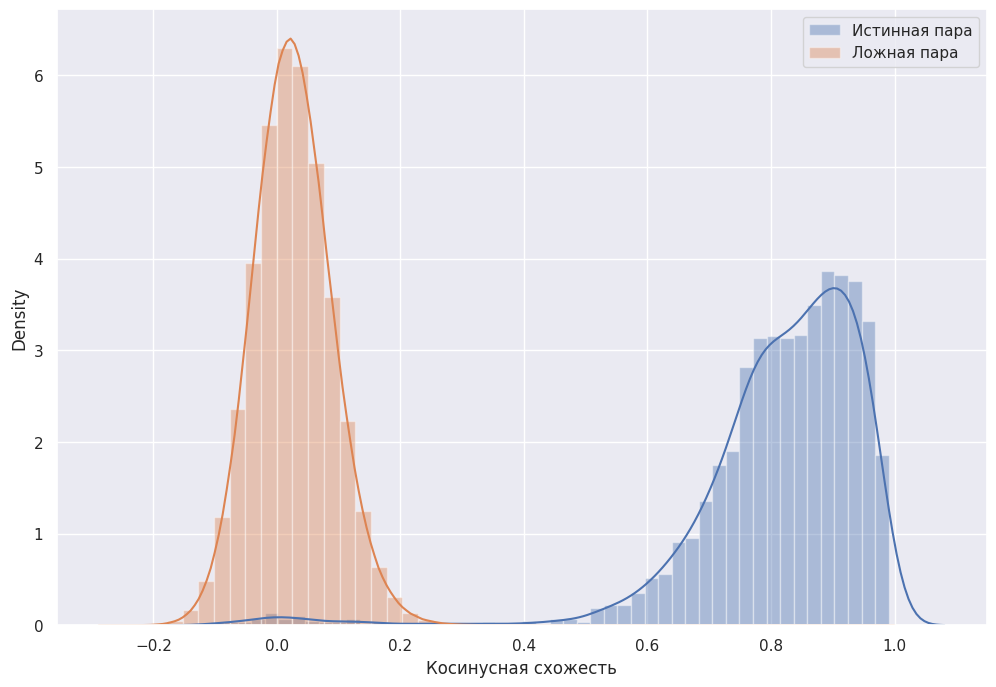

In [22]:
is_positive = pairs["is_positive"].values

true_match_scores = scores[is_positive]
wrong_match_scores = scores[is_positive == 0]
scores_distr = {
    "Истинная пара": true_match_scores,
    "Ложная пара": wrong_match_scores,
}
draw_score_distr_plot(
    scores_distr=scores_distr,
    positive_pair_name="Истинная пара",
    negative_pair_name="Ложная пара",
)

### TAR@FAR кривая

In [24]:
fars = [10**ii for ii in np.arange(-6, 0, 4 / 100)] + [1]
threshes, recalls = [], []
wrong_match_scores_sorted = np.sort(wrong_match_scores)[::-1]
for far in fars:
    thresh = wrong_match_scores_sorted[
        max(int((wrong_match_scores_sorted.shape[0]) * far) - 1, 0)
    ]
    recall = np.sum(true_match_scores > thresh) / true_match_scores.shape[0]
    threshes.append(thresh)
    recalls.append(recall)

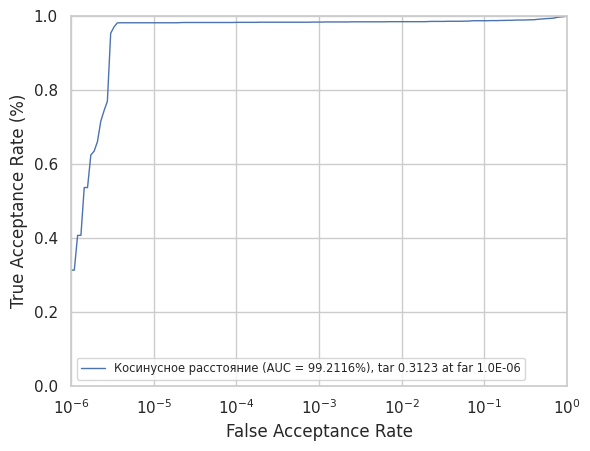

In [25]:
from sklearn.metrics import auc

sns.set_style("whitegrid")
fig = plt.figure()

auc_value = auc(fars, recalls)
label = "%s (AUC = %0.4f%%), tar %0.4f at far %.1E" % (
    "Косинусное расстояние",
    auc_value * 100,
    recalls[0],
    fars[0],
)
plt.plot(fars, recalls, lw=1, label=label)

plt.xlabel("False Acceptance Rate")
plt.xlim([fars[0], 1])
plt.xscale("log")
plt.ylabel("True Acceptance Rate (%)")
plt.ylim([0, 1])

# plt.grid(linestyle="--", linewidth=1)
plt.legend(fontsize="x-small")
# plt.tight_layout()
plt.show()